# Imports

In [49]:
import numpy as np
import pandas as pd 
import random 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d

from scipy.special import softmax
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.optim as optim

from timeit import default_timer as timer
import sys

from sklearn.decomposition import PCA

from scipy.stats import norm

# Dataset

In [50]:
df = pd.read_csv('ESS8_data.csv')

X = df[['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']].iloc[range(10000),:]
X = X.to_numpy().T

# Shapes of data:
N, M = X.T.shape

# Number of archetypes
K = 5

# Number of iterations
n_iter = 10000

# Define helper funcitons

In [51]:
def _apply_constraints_AB(A):
    m = nn.Softmax(dim=0)
    return m(A)


def _apply_constraints_beta(b,J):    
    m = nn.Softmax(dim=0)
    return torch.cumsum(m(b), dim=0)[:,:J-1]


def _apply_constraints_sigma(sigma):
    m = nn.Softplus()
    return m(sigma)

    
def _calculate_alpha(b,J):

    zeros = torch.zeros((len(b),1))
    ones = torch.ones((len(b),1))

    b_j = torch.cat((zeros,b),1)
    b_j_plus1 = torch.cat((b,ones),1)

    alphas = (b_j_plus1+b_j)/2

    return alphas


def _calculate_X_tilde(X,alphas):
    N = len(X)
    M = len(X[0,:])
    N_arange = [n for n in range(N) for m in range(M)]
    X_tilde = alphas[torch.flatten(X-1),N_arange]
    return X_tilde
    


def _calculate_X_hat(X_tilde,A,B):
    return X_tilde@B@A



def _calculate_D(b,X_hat,sigma):
    
    D = torch.rand(len(b[0,:])+2,len(X_hat),len(X_hat[0,:]))

    for j in range(len(b[0,:])+2):
        if j == 0:
            D[j] = torch.tensor(np.matrix(np.ones((len(X_hat),len(X_hat[0,:]))) * (-np.inf)))
        elif j == len(b[0,:])+1:
            D[j] = torch.tensor(np.matrix(np.ones((len(X_hat),len(X_hat[0,:]))) * (np.inf)))
        else:
            D[j] = (b[j-1].T-X_hat)/sigma

    return D


def _calculate_loss(D,X):

    N = len(X)
    M = len(X[0,:])
    stand_norm = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    
    D_cdf = stand_norm.cdf(D)
    P = D_cdf[1:]-D_cdf[:len(D)-1]
    
    inverse_log_P = -torch.log(P)
    
    N_arange = [n for n in range(N) for m in range(M)]
    M_arange = [m for m in range(M) for n in range(N)]

    loss = torch.sum(inverse_log_P[torch.flatten(X)-1,N_arange,M_arange])
            
    return loss


def _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J):
    
    A = _apply_constraints_AB(A_non_constraint)
    B = _apply_constraints_AB(B_non_constraint)
    b = _apply_constraints_beta(b_non_constraint,J)
    sigma = _apply_constraints_sigma(sigma_non_constraint)
    alphas = _calculate_alpha(b,J)
    
    X_tilde = _calculate_X_tilde(Xt,alphas)
    X_hat = _calculate_X_hat(X_tilde,A,B)
    D = _calculate_D(b,X_hat,sigma)
    loss = _calculate_loss(D,Xt)

    return loss
    
    
def _compute_archetypes(X, K, n_iter, lr, mute):

    N, _ = X.T.shape
    J = int((np.max(X)-np.min(X))+1)
    Xt = torch.autograd.Variable(torch.tensor(X), requires_grad=False)
    A_non_constraint = torch.autograd.Variable(torch.rand(K, N), requires_grad=True)
    B_non_constraint = torch.autograd.Variable(torch.rand(N, K), requires_grad=True)
    b_non_constraint = torch.autograd.Variable(torch.rand(N,J), requires_grad=True)
    sigma_non_constraint = torch.autograd.Variable(torch.rand(N), requires_grad=True)
    
    prev_loss = 100000
    
    optimizer = optim.Adam([A_non_constraint, 
                            B_non_constraint, 
                            b_non_constraint, 
                            sigma_non_constraint], amsgrad = True, lr = lr)
    
    for i in range(n_iter):
        optimizer.zero_grad()
        L = _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J)
        if i%10 == 0:   
            print(f"itt: {i}")
            print(f"loss improvment: {prev_loss-L}")
            prev_loss = L
        L.backward()
        optimizer.step() 
        
    # Compute the final error
    loss_f = _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J).item()
    Z_f = (X@_apply_constraints_AB(B_non_constraint).detach().numpy())
    A_f = _apply_constraints_AB(A_non_constraint).detach().numpy()
    B_f = _apply_constraints_AB(B_non_constraint).detach().numpy()
    b_f = _apply_constraints_beta(b_non_constraint,J)
    alphas_f = _calculate_alpha(b_f,J)
    X_tilde_f = _calculate_X_tilde(Xt,alphas_f).detach().numpy()
    X_hat_f = _calculate_X_hat(X_tilde_f,A_f,B_f)

    
    print("▣ The final loss was: {0}.".format(round(loss_f,2)))

    print(f"b: {b_f}")
    print(f"alphas: {alphas_f}")
    
    return A_f, B_f, b_f, Z_f, loss_f, X_tilde_f, X_hat_f

In [52]:
A, B, b, Z, RSS, X_hat, X_tilde = _compute_archetypes(X,5,1000,0.001,False)

torch.Size([10000, 6])


IndexError: too many indices for tensor of dimension 2

In [ ]:
print(X_hat.shape)
print(X_tilde.shape)
print(f"X_hat, max: {np.max(X_hat)}, ,min: {np.min(X_hat)}")
print(f"X_tilde, max: {np.max(X_tilde)}, ,min: {np.min(X_tilde)}")

(21, 10000)
(21, 10000)
X_hat, max: 0.9861994981765747, ,min: 0.014494326896965504
X_tilde, max: 0.5449355244636536, ,min: 0.26387324929237366


# Define 2d plots

In [ ]:
def _2dplot(Z,X):
        
        pca = PCA(n_components=2)
        pca.fit(Z.T)
        
        Z_pca = pca.transform(Z.T)
        X_pca = pca.transform(X.T)
        
        #line_1 = []
        #line_2 = []
        #lines = []
        #distances = []
        
        #for arch in Z_pca:
        #    for other in Z_pca:
        #        lines.append([arch[0],arch[1],other[0],other[1]])
        #        distances.append(np.linalg.norm(np.mean([arch,other], axis = 1)))
        #        line_1.append(arch[0])
        #        line_1.append(other[0])
        #        line_2.append(arch[1])
        #        line_2.append(other[1])
        
        plt.rcParams["figure.figsize"] = (10,10)
        #plt.plot(line_1, line_2, '-', c = "red", linewidth=0.5)
        plt.scatter(X_pca[:,0], X_pca[:,1], c ="blue", s = 3)
        plt.scatter(Z_pca[:,0], Z_pca[:,1], marker ="^", c ="red", s = 450)
        
        plt.show()

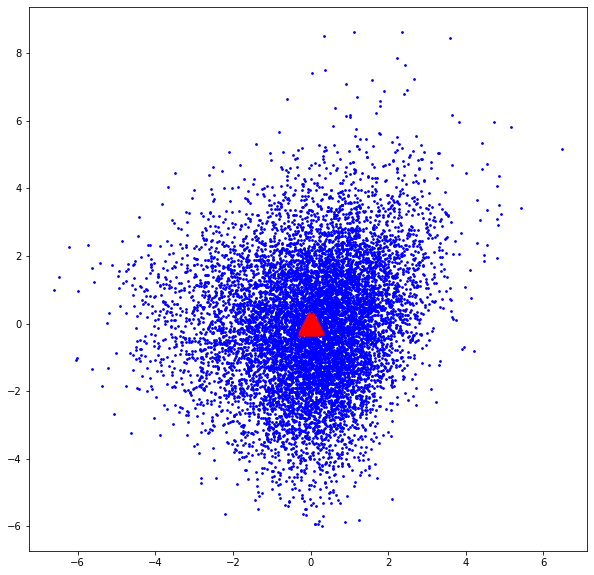

In [ ]:
_2dplot(Z,X)

# Define 2d plots 2

In [ ]:
def _2dplot(Z,X):
        
        plt.rcParams["figure.figsize"] = (10,10)
        #plt.plot(line_1, line_2, '-', c = "red", linewidth=0.5)
        plt.scatter(X[0,:], X[1,:], c ="blue", s = 3)
        plt.scatter(Z[0,:], Z[1,:], marker ="^", c ="red", s = 450)
        
        plt.show()

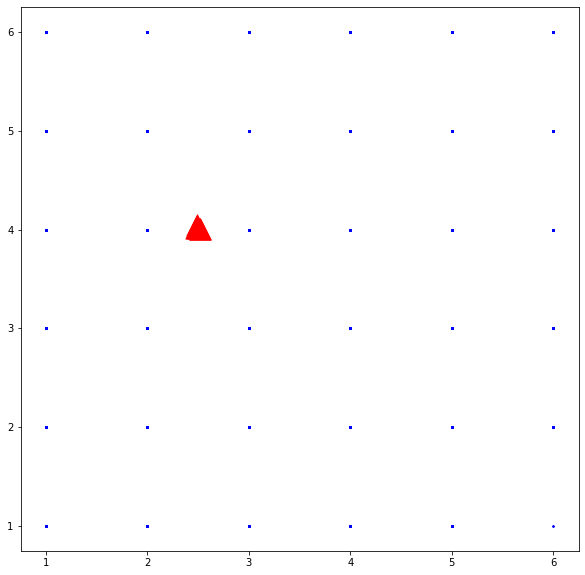

In [ ]:
_2dplot(Z,X)

# Define 2d plots 3

In [ ]:
def _barplot(Z,columns):
    archetype_num = 1
    for archetype in Z.T:
        fig, ax = plt.subplots()
        ax.set_ylabel('Value')
        ax.set_title('Archeype {0}'.format(archetype_num))
        ax.bar(np.arange(len(archetype)),archetype)
        ax.set_xticks(np.arange(len(archetype)))
        ax.set_xticklabels(labels=columns)
        plt.ylim(np.min(Z-1), np.max(Z+1))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
        fig.set_size_inches(8, 8)
            
        plt.show()
            
        archetype_num += 1

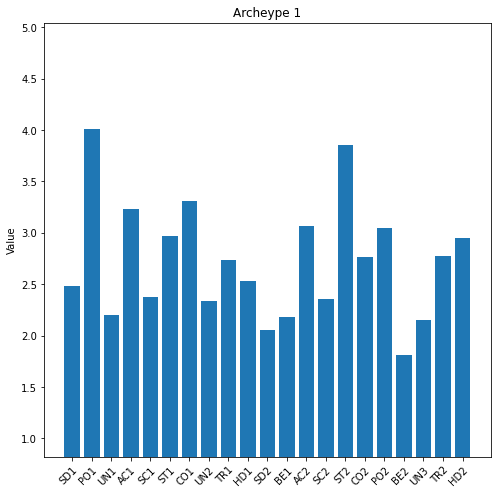

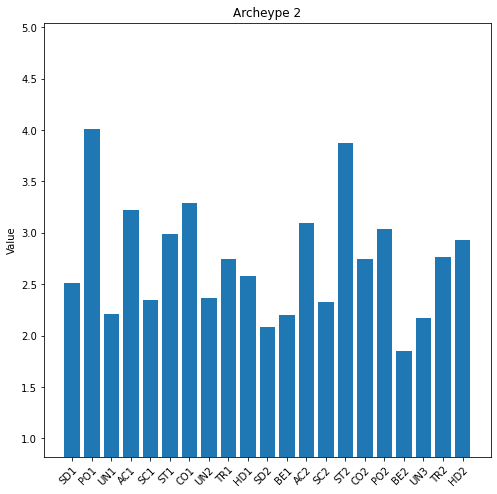

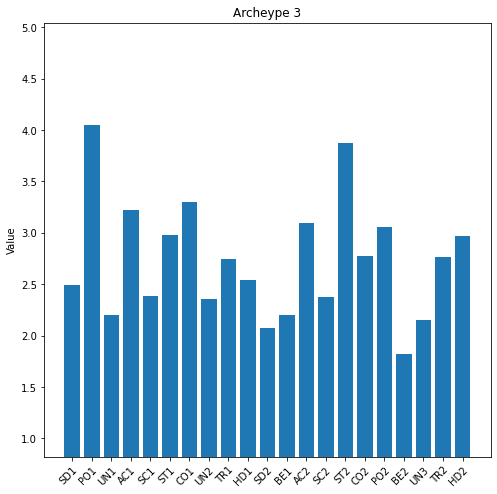

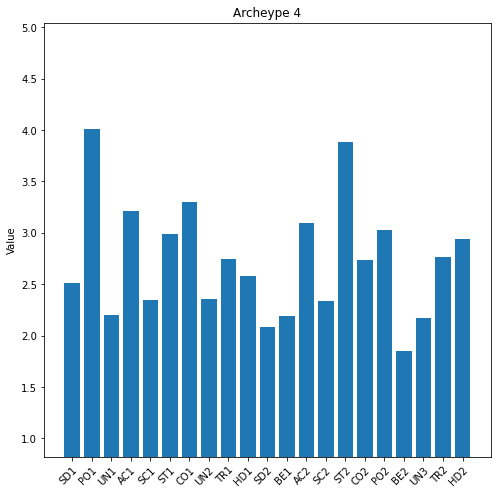

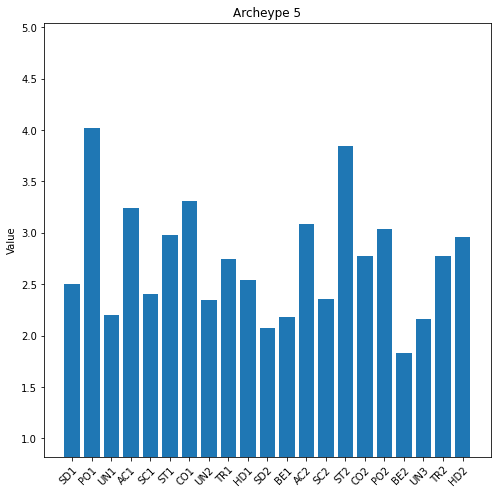

In [ ]:
columns = ['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']

_barplot(Z,columns)